<a href="https://colab.research.google.com/github/abdulquawiyy-owolabi/Deep-Learning/blob/main/Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import time
import copy
import torch
import pathlib

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.auto import tqdm
from IPython.display import HTML
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [3]:
# @title Loading Animal Faces data
import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'afhq'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"

if not os.path.exists(fname):
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)

  if os.path.exists(fname):
    with ZipFile(fname, 'r') as zfile:
      zfile.extractall(f".")
      os.remove(fname)

print("Download completed.")

Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


In [4]:
# @title Loading Animal Faces Randomized data

print("Start downloading and unzipping `Randomized AnimalFaces` dataset...")

names = ['afhq_random_32x32', 'afhq_10_32x32']
urls = ["https://osf.io/9sj7p/download",
        "https://osf.io/wvgkq/download"]


for i, name in enumerate(names):
  url = urls[i]
  fname = f"{name}.zip"

  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)

    if os.path.exists(fname):
      with ZipFile(fname, 'r') as zfile:
        zfile.extractall(f".")
        os.remove(fname)

print("Download completed.")

Start downloading and unzipping `Randomized AnimalFaces` dataset...
Download completed.


In [5]:
# @title Plotting functions
def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_weights(norm, labels, ws,
                 title='Weight Size Measurement'):
  plt.figure(figsize=[8, 6])
  plt.title(title)
  plt.ylabel('Frobenius Norm Value')
  plt.xlabel('Model Layers')
  plt.bar(labels, ws)
  plt.axhline(y=norm,
              linewidth=1,
              color='r',
              ls='--',
              label='Total Model F-Norm')
  plt.legend()
  plt.show()


def early_stop_plot(train_acc_earlystop,
                    val_acc_earlystop, best_epoch):
  plt.figure(figsize=(8, 6))
  plt.plot(val_acc_earlystop,label='Val - Early',c='red',ls = 'dashed')
  plt.plot(train_acc_earlystop,label='Train - Early',c='red',ls = 'solid')
  plt.axvline(x=best_epoch, c='green', ls='dashed',
              label='Epoch for Max Val Accuracy')
  plt.title('Early Stopping')
  plt.ylabel('Accuracy (%)')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

In [6]:
# @title Set random seed
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
                "if possible, in the menu under `Runtime` -> "
                        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")
  return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [32]:
class AnimalNet(nn.Module):
  def __init__(self):
    super(AnimalNet, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 1028)
    self.fc2 = nn.Linear(1028, 128)
    self.fc3 = nn.Linear(128, 3)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output



In [9]:
def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    if reg_function1 is None:
      loss = criterion(output, target)
    elif reg_function2 is None:
      loss = criterion(output, target)+args['lambda']*reg_function1(model)
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None):

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, device=device)
    val_acc = test(trained_model, val_loader, device=device)
    param_norm = calculate_frobenius(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, param_norm_list, trained_model

Random seed 2021 has been set.
Frobenius norm of Single linear layer: 0.6572162508964539


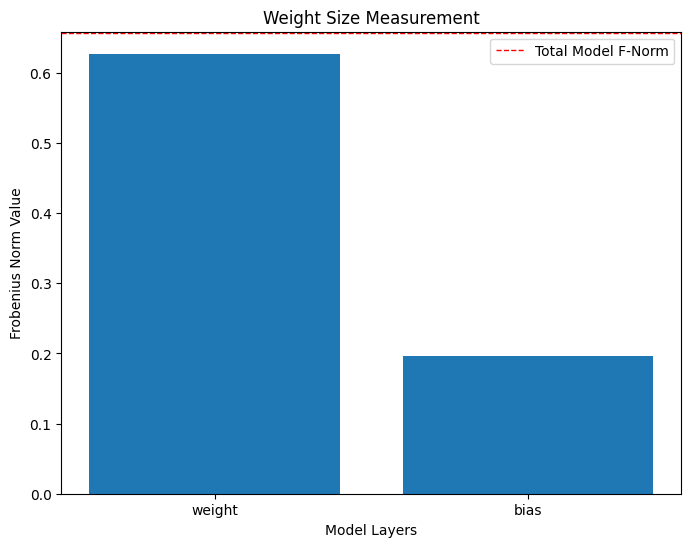

In [10]:
def calculate_frobenius(model):
  # initialise variables
  norm, ws, labels = 0.0, [], []

  for name, param in model.named_parameters():
    p = torch.sum(param**2)
    norm += p

    ws.append((p**0.5).cpu().detach().numpy())
    labels.append(name)
  # Take the square roote of the sum of the squared parameters.
  norm = (norm**0.5).cpu().detach().numpy()

  return norm, ws, labels


set_seed(SEED)
net = nn.Linear(10,1)
norm, ws, labels = calculate_frobenius(net)
print(f"Frobenius norm of Single linear layer: {norm}")
plot_weights(norm, labels, ws)

Frobenius norm of Single linear layer: 18.83500862121582


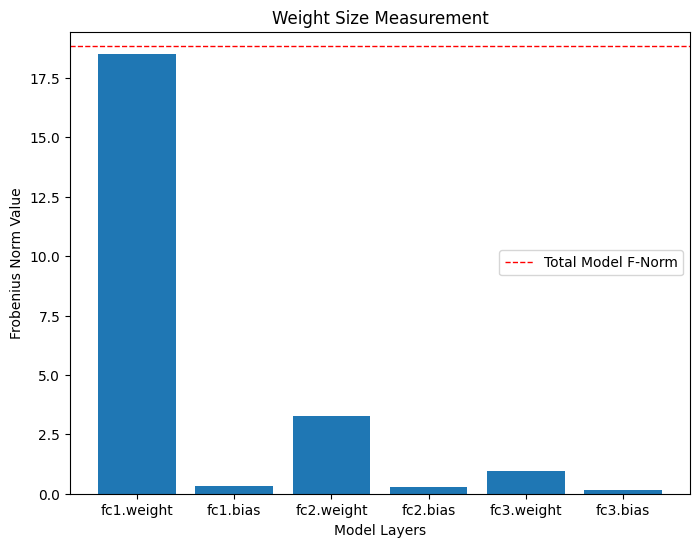

In [11]:
model = AnimalNet()
norm, ws, labels = calculate_frobenius(model)
print(f"Frobenius norm of Single linear layer: {norm}")
plot_weights(norm, labels, ws)

Random seed 2021 has been set.


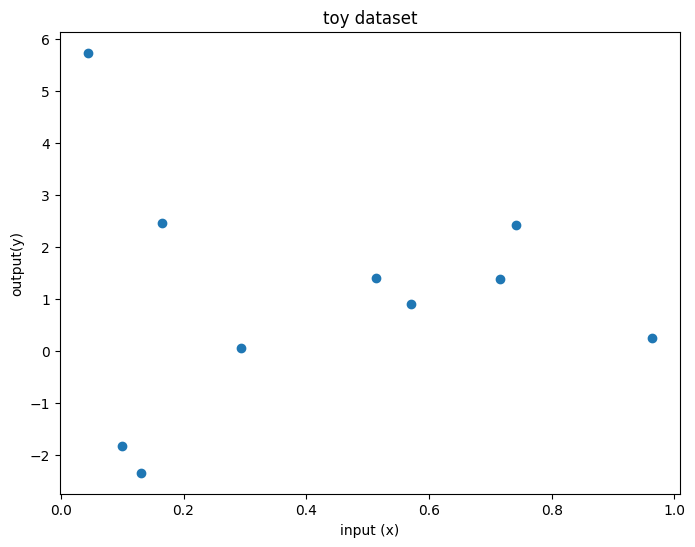

In [12]:
# @title Overparameterisation and Overfitting

set_seed(SEED)

# create trainig data
X = torch.rand((10,1))
# output
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(),Y.numpy())
plt.xlabel('input (x)')
plt.ylabel('output(y)')
plt.title('toy dataset')
plt.show()


# Creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))

In [13]:
# @title Build Its Model Architecture

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(1, 300)
    self.fc2 = nn.Linear(300, 500)
    self.fc3 = nn.Linear(500,1)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    output = self.fc3(x)
    return output

In [14]:
# @title Define the Parameters for Model Training
set_seed(SEED)
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

iters = 0
normi, wsi, label = calculate_frobenius(model)

Random seed 2021 has been set.


In [15]:
# @title Train the Model

train_loss = []
test_loss = []

# model norm
model_norm = []

# store weight
norm_per_layer = []

max_epoch = 10000
running_preds = np.empty((40, int(max_epoch/500+1)))

for epoch in tqdm(range(max_epoch)):
  # Frobenius norm per epoch
  norm, pl, layer = calculate_frobenius(model)

  # Training
  model_norm.append(norm)
  norm_per_layer.append(pl)
  model.train()
  optimizer.zero_grad()
  predictions = model(X)
  loss = criterion(predictions, Y)
  loss.backward()
  optimizer.step()

  train_loss.append(loss.item())
  model.eval()
  Y_test = model(X_test)
  loss = criterion(Y_test, 2*X_test)
  test_loss.append(loss.data)

  if (epoch % 5500 ==00 or epoch == max_epoch -1):
    running_preds[:, iters] = Y_test[:, 0, 0].detach().numpy()
    iters += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
# # @title Animation

# set_seed(seed=SEED)
# # Create a figure and axes
# fig = plt.figure(figsize=(14, 5))
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122)
# # Organizing subplots
# plot1, = ax1.plot([],[])
# plot2 = ax2.bar([], [])


# def frame(i):
#   ax1.clear()
#   title1 = ax1.set_title('')
#   ax1.set_xlabel("Input(x)")
#   ax1.set_ylabel("Output(y)")

#   ax2.clear()
#   ax2.set_xlabel('Layer names')
#   ax2.set_ylabel('Frobenius norm')
#   title2 = ax2.set_title('Weight Measurement: Forbenius Norm')

#   ax1.scatter(X.numpy(),Y.numpy())
#   plot1 = ax1.plot(X_test[:,0,:].detach().numpy(),
#                    running_preds[:,i])
#   title1.set_text(f'Epochs: {i * 500}')
#   plot2 = ax2.bar(labels, norm_per_layer[i*500])
#   plt.axhline(y=model_norm[i*500], linewidth=1,
#               color='r', ls='--',
#               label=f'Norm: {model_norm[i*500]:.2f}')
#   plt.legend()

#   return plot1, plot2


# anim = animation.FuncAnimation(fig, frame, frames=range(20),
#                                blit=False, repeat=False,
#                                repeat_delay=10000)
# html_anim = HTML(anim.to_html5_video())
# plt.close()

# import IPython
# IPython.display.display(html_anim)

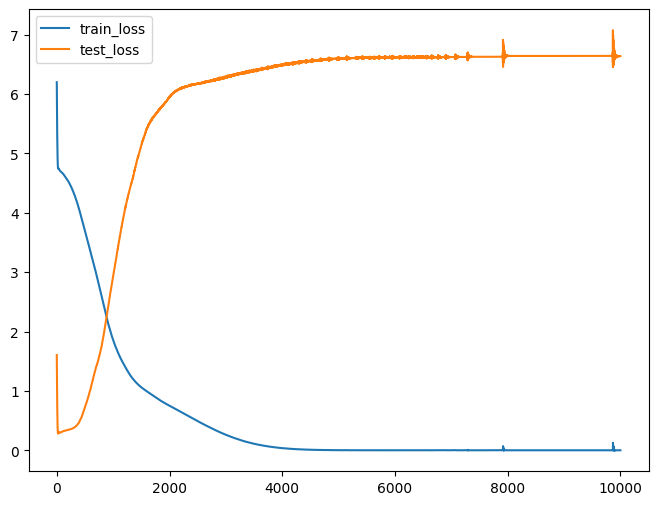

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.show()

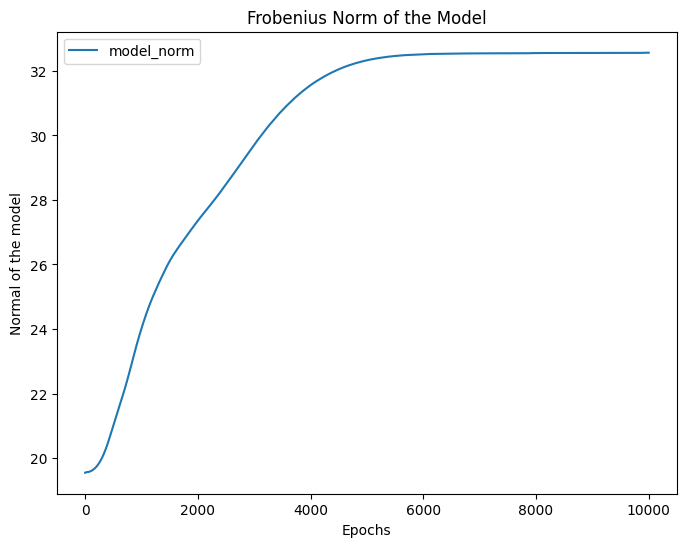

In [18]:
# @title Frobenius Norm of the Model

plt.figure(figsize=(8, 6))
plt.plot(model_norm, label='model_norm')
plt.ylabel('Normal of the model')
plt.xlabel('Epochs')
plt.title('Frobenius Norm of the Model')
plt.legend()
plt.show()

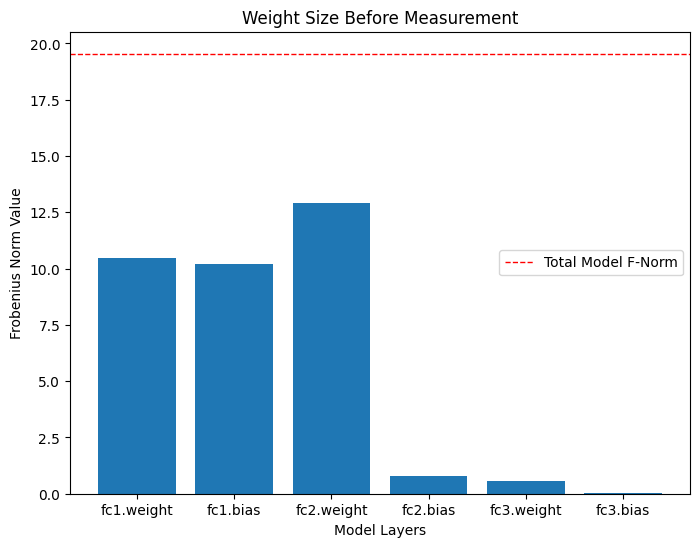

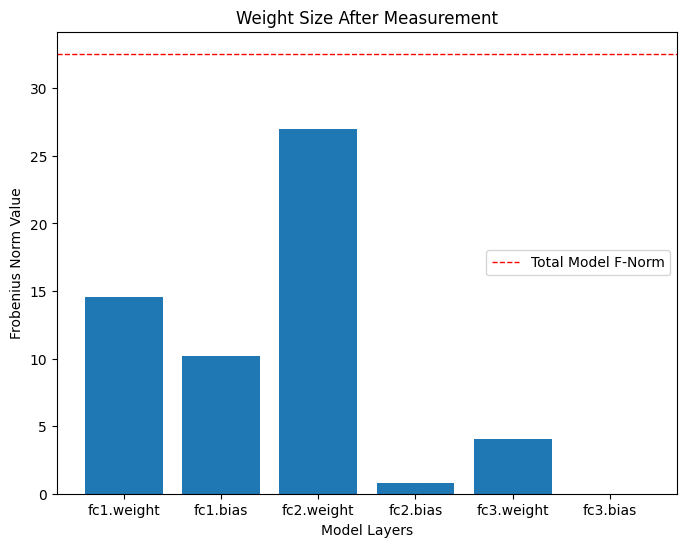

In [19]:
normf, wsf, label = calculate_frobenius(model)
plot_weights(float(normi), label, wsi,
             title='Weight Size Before Measurement')
plot_weights(float(normf), label, wsf,
             title='Weight Size After Measurement')

In [20]:
# Dataloaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

# Defining number of examples for train, val test
len_train, len_val, len_test = 100, 100, 14430

train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
data_path = pathlib.Path('.')/'afhq'  # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

In [21]:
# @title DataLoader for the Original Dataset
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

img_train_data, img_val_data, _ = torch.utils.data.random_split(
    img_dataset, [len_train, len_val, len_test],)

# Create train_loader and valloader
train_loader = torch.utils.data.DataLoader(img_train_data,
                                           batch_size=batch_size,
                                           num_workers=2,
                                          #  shuffle=True,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(img_val_data,
                                         batch_size=1000,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

In [22]:
# @title Dataloader for the Random Dataset

g_seed = torch.Generator()
g_seed.manual_seed(SEED+1)

data_path = pathlib.Path('.')/'afhq_random_32x32/afhq_random'  # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
random_img_train_data, random_img_val_data, _ = torch.utils.data.random_split(
    img_dataset, [len_train, len_val, len_test],)

rand_train_loader = torch.utils.data.DataLoader(random_img_train_data,
                                           batch_size=batch_size,
                                           num_workers=2,
                                          #  shuffle=True,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
rand_val_loader = torch.utils.data.DataLoader(random_img_val_data,
                                         batch_size=1000,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

In [23]:
# @title Dataloaders for the Partially Random Dataset

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED + 1)

# Splitting data between training and validation dataset for partially randomized data
data_path = pathlib.Path('.')/'afhq_10_32x32/afhq_10' # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
partially_random_train_data, partially_random_val_data,_ = torch.utils.data.random_split(img_dataset, [len_train, len_val, len_test])

# Training and Validation loader for partially randomized data
partial_rand_train_loader = torch.utils.data.DataLoader(partially_random_train_data,
                                                        batch_size=batch_size,
                                                        num_workers=2,
                                                        worker_init_fn=seed_worker,
                                                        generator=g_seed)

partial_rand_val_loader = torch.utils.data.DataLoader(partially_random_val_data,
                                                      batch_size=1000,
                                                      num_workers=2,
                                                      worker_init_fn=seed_worker,
                                                      generator=g_seed)

In [24]:
class AniNet(nn.Module):
  def __init__(self):
    super(AniNet, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 124)
    self.fc2 = nn.Linear(124, 64)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

In [25]:
set_seed(seed=SEED)
normi, wsi, label = calculate_frobenius(AniNet())

Random seed 2021 has been set.


Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

Time to Memorize the dataset: 253.28 seconds


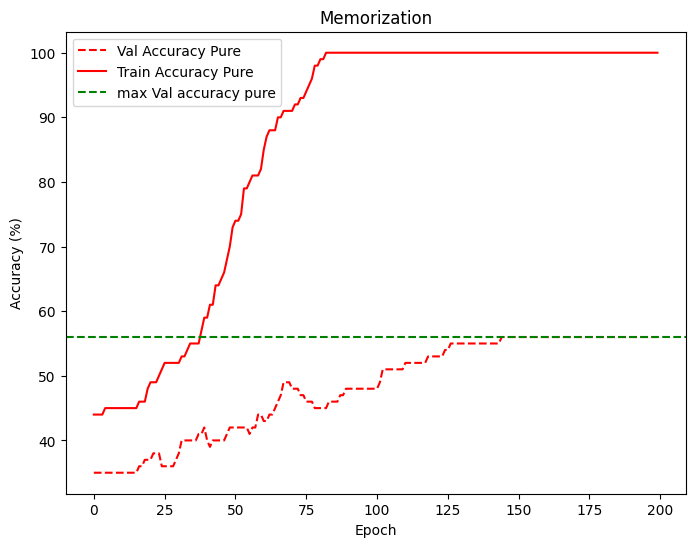

In [26]:
# @title Train AniNet() model

args = {
    'epochs': 200,
    'lr':5e-3,
    'momentum':0.9,
    'device':DEVICE,
}

set_seed(seed=SEED)
model = AniNet()

start_time = time.time()

val_acc_pure, train_acc_pure, _, model = main(args,
                                              model=model,
                                              train_loader= train_loader,
                                              val_loader=val_loader)
end_time = time.time()
print(f"Time to Memorize the dataset: {end_time - start_time:.2f} seconds")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure, label='Val Accuracy Pure', c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure', c='red', ls='solid')
plt.axhline(y=max(val_acc_pure), c='green', ls='dashed',
            label='max Val accuracy pure')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

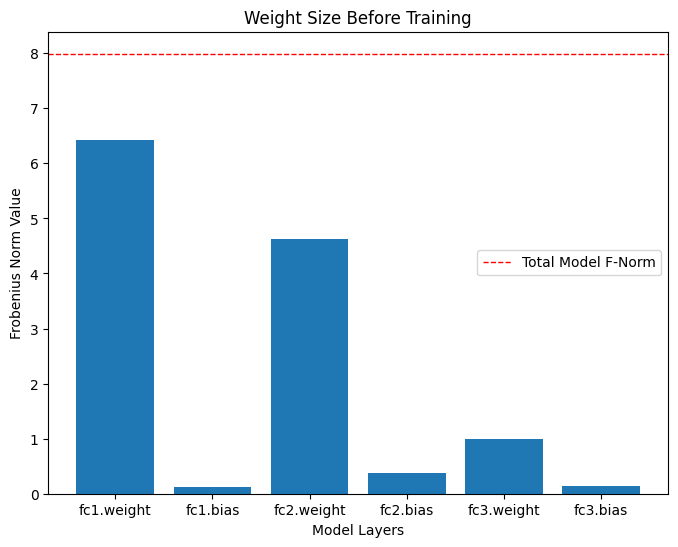

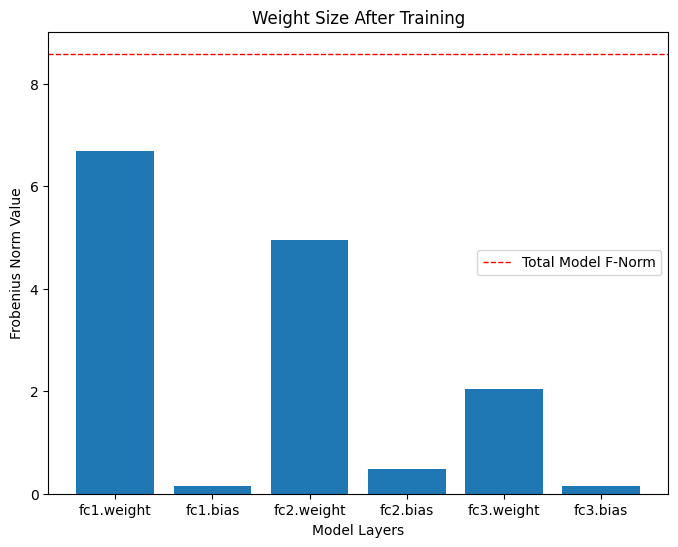

In [27]:
normf, wsf, label = calculate_frobenius(model)

plot_weights(float(normi), label, wsi, title='Weight Size Before Training')
plot_weights(float(normf), label, wsf, title='Weight Size After Training')

Image class: wild


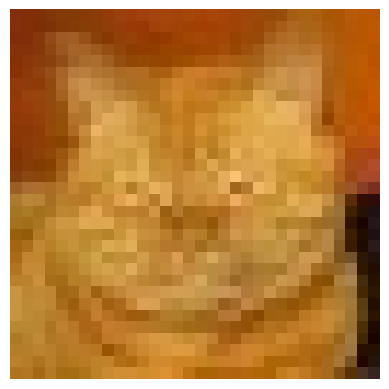

In [28]:
classes = ('cat', 'dog', 'wild')

def visualise_data(dataloader):
  for idx, (data, label) in enumerate(dataloader):
    plt.figure(idx)
    index = 56

    data = data[index].permute(1,2,0)*torch.tensor([00.5, 00.5,.5]) + torch.tensor([.5,.5,.5])

    # convert the torch tensor into numpy
    data = data.numpy()

    plt.imshow(data)
    plt.axis(False)
    image_class = classes[label[index].item()]
    print(f"Image class: {image_class}")
  plt.show()

visualise_data(rand_train_loader)

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

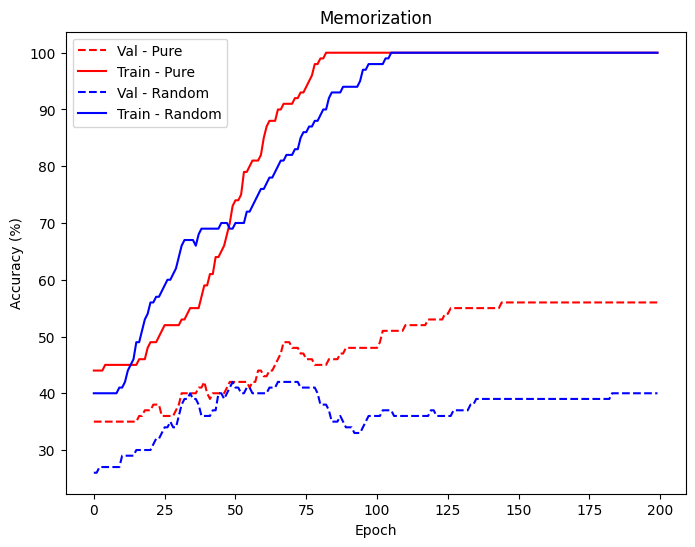

In [29]:
# @title Train the Network on the Shuffled Train data

args = {
    'epochs': 200,
    'lr':5e-3,
    'momentum':0.9,
    'device':DEVICE,
}

set_seed(seed=SEED)
model = AniNet()

val_acc_rand, train_acc_rand, _, model = main(args,
                                              model=model,
                                              train_loader= rand_train_loader,
                                              val_loader=rand_val_loader)
#  Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure,label='Val - Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train - Pure',c='red',ls = 'solid')
plt.plot(val_acc_rand,label='Val - Random',c='blue',ls = 'dashed')
plt.plot(train_acc_rand,label='Train - Random',c='blue',ls = 'solid')

plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [34]:
def early_stopping_main(args, model, train_loader, val_loader):
  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

  best_acc = 00.0
  best_epoch = 00.0
  patience = 20
  wait = 0

  val_acc_list, train_acc_list = [],[]
  for epoch in tqdm(range(args['epochs'])):
    # calculate train accuracy
    trained_model = train(args, model, train_loader, optimizer)
    train_acc = test(trained_model, train_loader, device=device)
    val_acc = test(trained_model, val_loader, device=device)

    if (val_acc > best_acc):
      best_acc = val_acc
      best_epoch = epoch
      wait = 0
    else:
      wait += 1

    if (wait > patience):
      print(f"Early Stopped on epoch {epoch}")
      break
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
  return val_acc_list, train_acc_list, trained_model, best_epoch

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

Early Stopped on epoch 22
Maximum Validation Accuracy is reached at epoch:  1


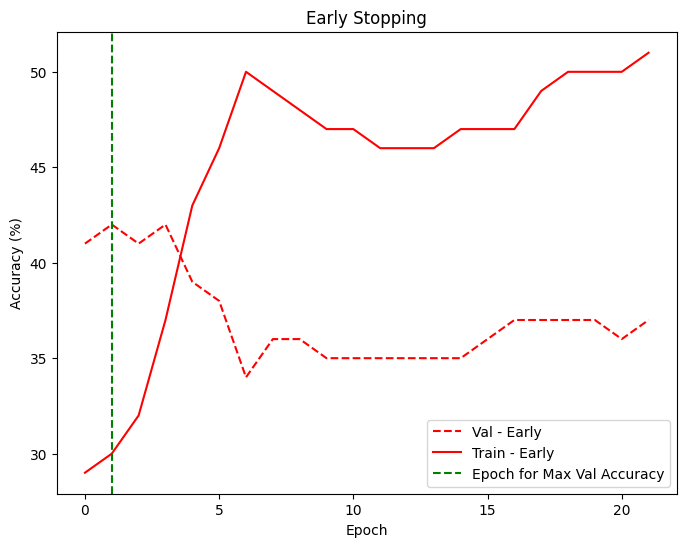

In [36]:
args = {
    'epochs': 200,
    'lr':5e-3,
    'momentum':0.99,
    'device':DEVICE,
}

set_seed(seed=SEED)
model = AnimalNet()

val_acc_earlystop, train_acc_earlystop, best_model, best_epoch = early_stopping_main(args, model, train_loader, val_loader)
print(f'Maximum Validation Accuracy is reached at epoch: {best_epoch:2d}')
early_stop_plot(train_acc_earlystop, val_acc_earlystop, best_epoch)

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

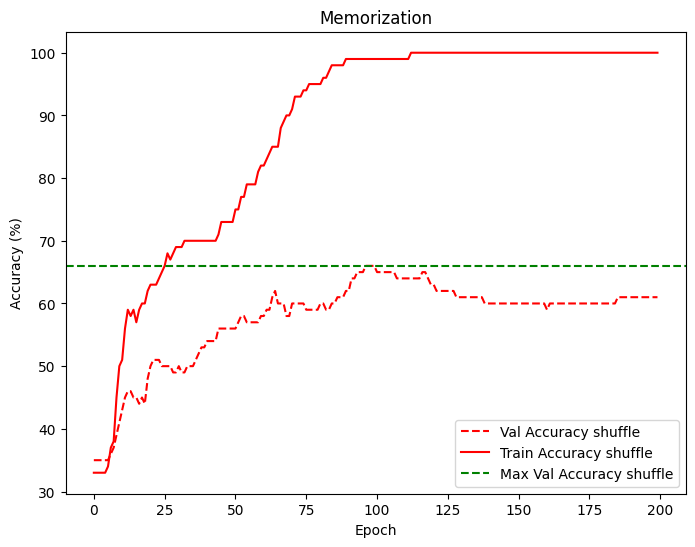

In [38]:
# Here we have 15% partially shuffled train data.

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}

# Intialize the model
set_seed(seed=SEED)
model = AniNet()

# Train the model
val_acc_shuffle, train_acc_shuffle, _, _, = main(args,
                                                 model,
                                                 partial_rand_train_loader,
                                                 val_loader)

# Train and test acc plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_shuffle, label='Val Accuracy shuffle', c='red', ls='dashed')
plt.plot(train_acc_shuffle, label='Train Accuracy shuffle', c='red', ls='solid')
plt.axhline(y=max(val_acc_shuffle), c='green', ls='dashed',
            label='Max Val Accuracy shuffle')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

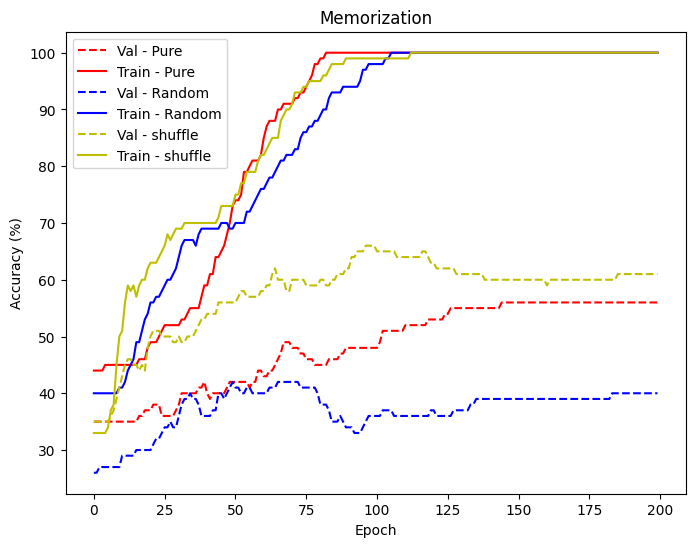

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure,label='Val - Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train - Pure',c='red',ls = 'solid')
plt.plot(val_acc_rand,label='Val - Random',c='blue',ls = 'dashed')
plt.plot(train_acc_rand,label='Train - Random',c='blue',ls = 'solid')
plt.plot(val_acc_shuffle, label='Val - shuffle', c='y', ls='dashed')
plt.plot(train_acc_shuffle, label='Train - shuffle', c='y', ls='solid')

plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()